In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Common packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from scipy.stats import uniform, randint

# Sklearn for ML
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

# Custom packages
os.chdir("C:/Users/Titouan/Documents/HepavirAlgo")
pd.set_option("display.max_columns", None)
import funcsnds.predstatus as ps
import funcsnds.globalvar as gv

In [3]:
path_snds = "D:/Data/HEPAT_VUE_30012023/HEP_CSV/"
snds_hepather = pd.read_csv("data/chainage_snds_statut_hepather.csv").drop_duplicates()

# Création du dataset

In [4]:
cat_target = "chronique_B"

affine_used = {
    "DCIR" : ["ER_BIO_F", "ER_CAM_F", "ER_PHA_F", "ER_UCD_F"],
    "MCO"  : ["A", "D", "UM", "FL", "FM"],
    "SSR"  : ["D", "FL"]
}

curated_vars = None
# Si on voulait choisir les variables à la main
#curated_vars = gv.chronique_b_curated
how_many_vars = 10

In [5]:
# Creation du dataset, à réaliser une fois, sauf si on change les variables
range_year = range(12,22)
_ = ps.create_snds_allyear_allnumenq(range_year, affine_used, how_many_vars, curated_vars, cat_target, path_snds)

Flatten SNDS created for year 12
Flatten SNDS created for year 13
Flatten SNDS created for year 14
Flatten SNDS created for year 15
Flatten SNDS created for year 16
Flatten SNDS created for year 17
Flatten SNDS created for year 18
Flatten SNDS created for year 19
Flatten SNDS created for year 20
Flatten SNDS created for year 21


In [6]:
# Moyennisation des données sur 3 ans
type_agreg = "mean"
df_final, var_predict = ps.create_dateset_threeyears(type_agreg, snds_hepather, affine_used, how_many_vars, curated_vars, cat_target, path_snds)

# Si on voulait garder une seule année
#df_final, var_predict = ps.create_dateset_oneyear(snds_hepather, affine_used, how_many_vars, curated_vars, cat_target, path_snds)

In [8]:
# Permet de se rendre compte si des variables sont "largement distribuées" ce qui pourrait ralentir le processus sur le portail CNAM
for column_name in df_final.columns:
    column = df_final[column_name]
    perc = np.round(100*(column == 0).sum()/len(column),1)
    print("Perc in", column_name, " is : ", perc)

Perc in NUM_ENQ  is :  0.0
Perc in BIO_PRS_IDE/1208  is :  48.4
Perc in BIO_PRS_IDE/1740  is :  96.4
Perc in BIO_PRS_IDE/1806  is :  52.1
Perc in BIO_PRS_IDE/2004  is :  80.5
Perc in BIO_PRS_IDE/2007  is :  90.8
Perc in BIO_PRS_IDE/320  is :  48.1
Perc in BIO_PRS_IDE/322  is :  67.2
Perc in BIO_PRS_IDE/323  is :  72.7
Perc in BIO_PRS_IDE/351  is :  76.3
Perc in BIO_PRS_IDE/353  is :  90.4
Perc in BIO_PRS_IDE/354  is :  91.0
Perc in BIO_PRS_IDE/4120  is :  75.5
Perc in BIO_PRS_IDE/4124  is :  52.2
Perc in BIO_PRS_IDE/4125  is :  88.5
Perc in BIO_PRS_IDE/4500  is :  100.0
Perc in BIO_PRS_IDE/4711  is :  99.8
Perc in BIO_PRS_IDE/519  is :  13.5
Perc in BIO_PRS_IDE/522  is :  8.8
Perc in BIO_PRS_IDE/563  is :  71.1
Perc in BIO_PRS_IDE/996  is :  33.6
Perc in CAM_PRS_IDE/BGQP002  is :  83.2
Perc in CAM_PRS_IDE/BZQK001  is :  91.3
Perc in CAM_PRS_IDE/DEQP003  is :  77.5
Perc in CAM_PRS_IDE/DZQM006  is :  79.8
Perc in CAM_PRS_IDE/HBGD036  is :  91.7
Perc in CAM_PRS_IDE/HBJD001  is :  68.8
Per

In [9]:
# # En utilisant le split de sklearn
# X_train, X_test, y_train, y_test = train_test_split(df_final[var_predict], df_final[cat_target], test_size = 0.3)
# dtrain = xgb.DMatrix(X_train, label = y_train)
# dtest = xgb.DMatrix(X_test, label = y_test)

# Custom function pour resampler et "balanced" dans l'échantillon d'entraînement
# Le seed n'est pas figé à dessein, pour ne pas "overfitter le seed"
#X_cv, y_cv, X_test, y_test, num_enq_train = ps.prepare_data(cat_target, var_predict, df_final, size_train = 0.8)

X_cv, X_test, y_cv, y_test = train_test_split(df_final[var_predict], df_final[cat_target], test_size = 0.2)
num_enq_train = list(df_final.iloc[X_cv.index]["NUM_ENQ"])
num_enq_test = list(df_final.iloc[X_test.index]["NUM_ENQ"])
spw = (len(y_cv) - y_cv.sum())/y_cv.sum()
print(f"Le déséquilibre dans l'échantillon d'entraînement est de {np.round(spw, 1)} fois plus de négatifs que positifs")

Le déséquilibre dans l'échantillon d'entraînement est de 2.5 fois plus de négatifs que positifs


# Entraînement régression Logisitique

En raison de problèmes d'importation des modèles XGBoost au format `.json` sur la plateforme CNAM, un modèle linéaire a été estimé

In [10]:
%%time

## Random search XGB

model_simple = LogisticRegression(class_weight=spw, max_iter = 2000)

param_distrib_log = {
    "C" : uniform(0.1, 2)
}

clf_log = RandomizedSearchCV(
    model_simple, 
    param_distributions = param_distrib_log,
    scoring = "balanced_accuracy", 
    n_iter = 50, cv = 4, 
    n_jobs = 1,
    verbose = 10,
    return_train_score = True
)

clf_log.fit(X_cv, y_cv)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV 1/4; 1/50] START C=0.8050192613153869.......................................
[CV 1/4; 1/50] END C=0.8050192613153869;, score=(train=0.952, test=0.937) total time=   0.4s
[CV 2/4; 1/50] START C=0.8050192613153869.......................................
[CV 2/4; 1/50] END C=0.8050192613153869;, score=(train=0.951, test=0.948) total time=   0.4s
[CV 3/4; 1/50] START C=0.8050192613153869.......................................
[CV 3/4; 1/50] END C=0.8050192613153869;, score=(train=0.953, test=0.940) total time=   0.4s
[CV 4/4; 1/50] START C=0.8050192613153869.......................................
[CV 4/4; 1/50] END C=0.8050192613153869;, score=(train=0.948, test=0.940) total time=   0.4s
[CV 1/4; 2/50] START C=0.4744143443579213.......................................
[CV 1/4; 2/50] END C=0.4744143443579213;, score=(train=0.949, test=0.937) total time=   0.3s
[CV 2/4; 2/50] START C=0.4744143443579213...........................

[CV 4/4; 12/50] END C=0.5458106521054223;, score=(train=0.947, test=0.941) total time=   0.3s
[CV 1/4; 13/50] START C=1.7161826978467403......................................
[CV 1/4; 13/50] END C=1.7161826978467403;, score=(train=0.953, test=0.940) total time=   0.6s
[CV 2/4; 13/50] START C=1.7161826978467403......................................
[CV 2/4; 13/50] END C=1.7161826978467403;, score=(train=0.954, test=0.949) total time=   0.6s
[CV 3/4; 13/50] START C=1.7161826978467403......................................
[CV 3/4; 13/50] END C=1.7161826978467403;, score=(train=0.955, test=0.940) total time=   0.6s
[CV 4/4; 13/50] START C=1.7161826978467403......................................
[CV 4/4; 13/50] END C=1.7161826978467403;, score=(train=0.949, test=0.939) total time=   0.6s
[CV 1/4; 14/50] START C=1.9337794253177925......................................
[CV 1/4; 14/50] END C=1.9337794253177925;, score=(train=0.953, test=0.940) total time=   0.7s
[CV 2/4; 14/50] START C=1.93377

[CV 3/4; 24/50] END C=1.5025873176026578;, score=(train=0.955, test=0.941) total time=   0.5s
[CV 4/4; 24/50] START C=1.5025873176026578......................................
[CV 4/4; 24/50] END C=1.5025873176026578;, score=(train=0.949, test=0.940) total time=   0.5s
[CV 1/4; 25/50] START C=1.9050416351655837......................................
[CV 1/4; 25/50] END C=1.9050416351655837;, score=(train=0.953, test=0.940) total time=   0.6s
[CV 2/4; 25/50] START C=1.9050416351655837......................................
[CV 2/4; 25/50] END C=1.9050416351655837;, score=(train=0.955, test=0.949) total time=   0.5s
[CV 3/4; 25/50] START C=1.9050416351655837......................................
[CV 3/4; 25/50] END C=1.9050416351655837;, score=(train=0.955, test=0.939) total time=   0.5s
[CV 4/4; 25/50] START C=1.9050416351655837......................................
[CV 4/4; 25/50] END C=1.9050416351655837;, score=(train=0.950, test=0.937) total time=   0.5s
[CV 1/4; 26/50] START C=1.84747

[CV 2/4; 36/50] END C=1.968326319217542;, score=(train=0.955, test=0.949) total time=   0.6s
[CV 3/4; 36/50] START C=1.968326319217542.......................................
[CV 3/4; 36/50] END C=1.968326319217542;, score=(train=0.955, test=0.939) total time=   0.6s
[CV 4/4; 36/50] START C=1.968326319217542.......................................
[CV 4/4; 36/50] END C=1.968326319217542;, score=(train=0.950, test=0.937) total time=   0.6s
[CV 1/4; 37/50] START C=0.3887022529414431......................................
[CV 1/4; 37/50] END C=0.3887022529414431;, score=(train=0.949, test=0.936) total time=   0.3s
[CV 2/4; 37/50] START C=0.3887022529414431......................................
[CV 2/4; 37/50] END C=0.3887022529414431;, score=(train=0.946, test=0.944) total time=   0.3s
[CV 3/4; 37/50] START C=0.3887022529414431......................................
[CV 3/4; 37/50] END C=0.3887022529414431;, score=(train=0.949, test=0.936) total time=   0.3s
[CV 4/4; 37/50] START C=0.38870225

[CV 1/4; 48/50] END C=1.273978033413182;, score=(train=0.953, test=0.939) total time=   0.5s
[CV 2/4; 48/50] START C=1.273978033413182.......................................
[CV 2/4; 48/50] END C=1.273978033413182;, score=(train=0.953, test=0.949) total time=   0.5s
[CV 3/4; 48/50] START C=1.273978033413182.......................................
[CV 3/4; 48/50] END C=1.273978033413182;, score=(train=0.955, test=0.941) total time=   0.5s
[CV 4/4; 48/50] START C=1.273978033413182.......................................
[CV 4/4; 48/50] END C=1.273978033413182;, score=(train=0.950, test=0.940) total time=   0.5s
[CV 1/4; 49/50] START C=0.4041936977611359......................................
[CV 1/4; 49/50] END C=0.4041936977611359;, score=(train=0.949, test=0.936) total time=   0.3s
[CV 2/4; 49/50] START C=0.4041936977611359......................................
[CV 2/4; 49/50] END C=0.4041936977611359;, score=(train=0.946, test=0.944) total time=   0.3s
[CV 3/4; 49/50] START C=0.404193697

RandomizedSearchCV(cv=4,
                   estimator=LogisticRegression(class_weight=2.543277082199238,
                                                max_iter=2000),
                   n_iter=50, n_jobs=1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A58042AF10>},
                   return_train_score=True, scoring='balanced_accuracy',
                   verbose=10)

In [11]:
log_chosen = clf_log.best_estimator_

clf_log.best_params_

{'C': 1.273978033413182}

In [12]:
predictions_score = clf_log.predict_proba(X_test)[:,1]

In [13]:
predictions = clf_log.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      2301
         1.0       0.95      0.91      0.93       954

    accuracy                           0.96      3255
   macro avg       0.95      0.94      0.95      3255
weighted avg       0.96      0.96      0.96      3255



In [14]:
clf_log.best_estimator_.intercept_

array([0.00957484])

In [15]:
coef_model_log = pd.DataFrame([("CONSTANTE", + clf_log.best_estimator_.intercept_[0])] + list(zip(clf_log.feature_names_in_, clf_log.best_estimator_.coef_[0])), columns = ["Var", "Coef"])

In [16]:
if curated_vars == None :
    coef_model_log.to_csv("results/" + cat_target + "/coef_model_log.csv", sep = ";", index = False)
else:
    coef_model_log.to_csv("results/" + cat_target + "/coef_model_log_curated.csv", sep = ";", index = False)

In [17]:
final = pd.DataFrame(list(zip(y_test, predictions, predictions_score)), columns = ["True", "Pred", "Score"])

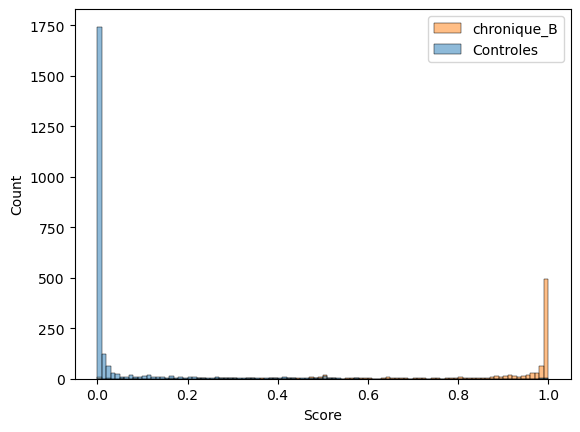

In [18]:
sns.histplot(data = final, x = "Score", hue = "True", bins = 100)
_ = plt.legend(labels = [cat_target, "Controles"])

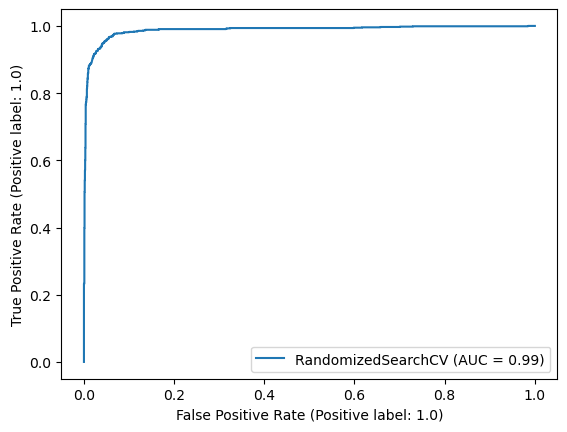

In [42]:
_ = RocCurveDisplay.from_estimator(clf_log, X_test, y_test)

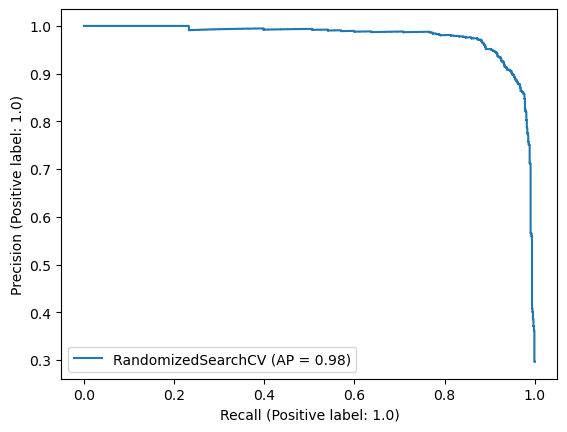

In [44]:
_ = PrecisionRecallDisplay.from_estimator(clf_log, X_test, predictions)

# Entraînement du XGBoost

In [1]:
## Recherche infructueuse avec plus de paramètres à parcourir

# %%time

# ## Random search XGB

# xgb_model = xgb.XGBClassifier()

# param_distrib_XGB = {
#     "n_estimators" : randint(50, 500),
#     "max_depth" : randint(2, 20),
#     "min_child_weight" : randint(1, 5),
#     "learning_rate" : uniform(0.01,1),
#     "gamma" : randint(0, 10)
# }

# clf = RandomizedSearchCV(
#     xgb_model, 
#     param_distributions = param_distrib_XGB,
#     scoring = "accuracy", 
#     n_iter = 200, cv = 4, 
#     n_jobs = 1,
#     verbose = 10
#     #random_state = 42
# )

# clf.fit(X_cv, y_cv)

In [20]:
%%time

## Random search XGB

xgb_model = xgb.XGBClassifier(scale_pos_weight = spw)

param_distrib_XGB = {
    "n_estimators" : randint(200, 300),
    "max_depth" : randint(1, 6),
}

clf = RandomizedSearchCV(
    xgb_model, 
    param_distributions = param_distrib_XGB,
    scoring = "balanced_accuracy", 
    n_iter = 50, cv = 4, 
    n_jobs = 1,
    verbose = 10,
    return_train_score = True
)

clf.fit(X_cv, y_cv)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV 1/4; 1/50] START max_depth=2, n_estimators=243..............................
[CV 1/4; 1/50] END max_depth=2, n_estimators=243;, score=(train=0.978, test=0.959) total time=   0.9s
[CV 2/4; 1/50] START max_depth=2, n_estimators=243..............................
[CV 2/4; 1/50] END max_depth=2, n_estimators=243;, score=(train=0.978, test=0.966) total time=   0.8s
[CV 3/4; 1/50] START max_depth=2, n_estimators=243..............................
[CV 3/4; 1/50] END max_depth=2, n_estimators=243;, score=(train=0.980, test=0.960) total time=   0.9s
[CV 4/4; 1/50] START max_depth=2, n_estimators=243..............................
[CV 4/4; 1/50] END max_depth=2, n_estimators=243;, score=(train=0.978, test=0.962) total time=   0.9s
[CV 1/4; 2/50] START max_depth=4, n_estimators=291..............................
[CV 1/4; 2/50] END max_depth=4, n_estimators=291;, score=(train=0.994, test=0.958) total time=   1.4s
[CV 2/4; 2/50] START ma

[CV 1/4; 12/50] END max_depth=2, n_estimators=249;, score=(train=0.979, test=0.959) total time=   0.9s
[CV 2/4; 12/50] START max_depth=2, n_estimators=249.............................
[CV 2/4; 12/50] END max_depth=2, n_estimators=249;, score=(train=0.979, test=0.966) total time=   0.9s
[CV 3/4; 12/50] START max_depth=2, n_estimators=249.............................
[CV 3/4; 12/50] END max_depth=2, n_estimators=249;, score=(train=0.980, test=0.960) total time=   0.9s
[CV 4/4; 12/50] START max_depth=2, n_estimators=249.............................
[CV 4/4; 12/50] END max_depth=2, n_estimators=249;, score=(train=0.978, test=0.963) total time=   0.9s
[CV 1/4; 13/50] START max_depth=3, n_estimators=298.............................
[CV 1/4; 13/50] END max_depth=3, n_estimators=298;, score=(train=0.989, test=0.959) total time=   1.2s
[CV 2/4; 13/50] START max_depth=3, n_estimators=298.............................
[CV 2/4; 13/50] END max_depth=3, n_estimators=298;, score=(train=0.989, test=0.9

[CV 2/4; 23/50] END max_depth=4, n_estimators=219;, score=(train=0.992, test=0.966) total time=   1.1s
[CV 3/4; 23/50] START max_depth=4, n_estimators=219.............................
[CV 3/4; 23/50] END max_depth=4, n_estimators=219;, score=(train=0.993, test=0.955) total time=   1.1s
[CV 4/4; 23/50] START max_depth=4, n_estimators=219.............................
[CV 4/4; 23/50] END max_depth=4, n_estimators=219;, score=(train=0.991, test=0.964) total time=   1.1s
[CV 1/4; 24/50] START max_depth=3, n_estimators=235.............................
[CV 1/4; 24/50] END max_depth=3, n_estimators=235;, score=(train=0.987, test=0.960) total time=   1.0s
[CV 2/4; 24/50] START max_depth=3, n_estimators=235.............................
[CV 2/4; 24/50] END max_depth=3, n_estimators=235;, score=(train=0.987, test=0.965) total time=   1.0s
[CV 3/4; 24/50] START max_depth=3, n_estimators=235.............................
[CV 3/4; 24/50] END max_depth=3, n_estimators=235;, score=(train=0.988, test=0.9

[CV 3/4; 34/50] END max_depth=4, n_estimators=229;, score=(train=0.993, test=0.955) total time=   1.2s
[CV 4/4; 34/50] START max_depth=4, n_estimators=229.............................
[CV 4/4; 34/50] END max_depth=4, n_estimators=229;, score=(train=0.991, test=0.962) total time=   1.2s
[CV 1/4; 35/50] START max_depth=2, n_estimators=267.............................
[CV 1/4; 35/50] END max_depth=2, n_estimators=267;, score=(train=0.979, test=0.959) total time=   1.0s
[CV 2/4; 35/50] START max_depth=2, n_estimators=267.............................
[CV 2/4; 35/50] END max_depth=2, n_estimators=267;, score=(train=0.979, test=0.966) total time=   1.0s
[CV 3/4; 35/50] START max_depth=2, n_estimators=267.............................
[CV 3/4; 35/50] END max_depth=2, n_estimators=267;, score=(train=0.980, test=0.959) total time=   1.0s
[CV 4/4; 35/50] START max_depth=2, n_estimators=267.............................
[CV 4/4; 35/50] END max_depth=2, n_estimators=267;, score=(train=0.979, test=0.9

[CV 4/4; 45/50] END max_depth=4, n_estimators=213;, score=(train=0.991, test=0.962) total time=   1.1s
[CV 1/4; 46/50] START max_depth=4, n_estimators=281.............................
[CV 1/4; 46/50] END max_depth=4, n_estimators=281;, score=(train=0.994, test=0.959) total time=   1.5s
[CV 2/4; 46/50] START max_depth=4, n_estimators=281.............................
[CV 2/4; 46/50] END max_depth=4, n_estimators=281;, score=(train=0.994, test=0.965) total time=   1.5s
[CV 3/4; 46/50] START max_depth=4, n_estimators=281.............................
[CV 3/4; 46/50] END max_depth=4, n_estimators=281;, score=(train=0.995, test=0.953) total time=   1.4s
[CV 4/4; 46/50] START max_depth=4, n_estimators=281.............................
[CV 4/4; 46/50] END max_depth=4, n_estimators=281;, score=(train=0.993, test=0.962) total time=   1.4s
[CV 1/4; 47/50] START max_depth=4, n_estimators=261.............................
[CV 1/4; 47/50] END max_depth=4, n_estimators=261;, score=(train=0.994, test=0.9

RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                            

In [21]:
xgb_chosen = clf.best_estimator_.get_booster()

clf.best_params_

{'max_depth': 4, 'n_estimators': 213}

In [2]:
# BEST_PARAMS = {'max_depth': 4, 'n_estimators': 213}

# clf = xgb.XGBClassifier(**BEST_PARAMS)

# clf.fit(X_cv, y_cv)

In [23]:
predictions_score = clf.predict_proba(X_test)[:,1]

In [24]:
predictions = clf.predict(C)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97      2301
         1.0       0.92      0.97      0.94       954

    accuracy                           0.96      3255
   macro avg       0.95      0.96      0.96      3255
weighted avg       0.97      0.96      0.96      3255



In [25]:
predictions_cv = clf.predict(X_cv)
print(classification_report(y_cv, predictions_cv))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      9344
         1.0       0.95      1.00      0.98      3674

    accuracy                           0.99     13018
   macro avg       0.98      0.99      0.98     13018
weighted avg       0.99      0.99      0.99     13018



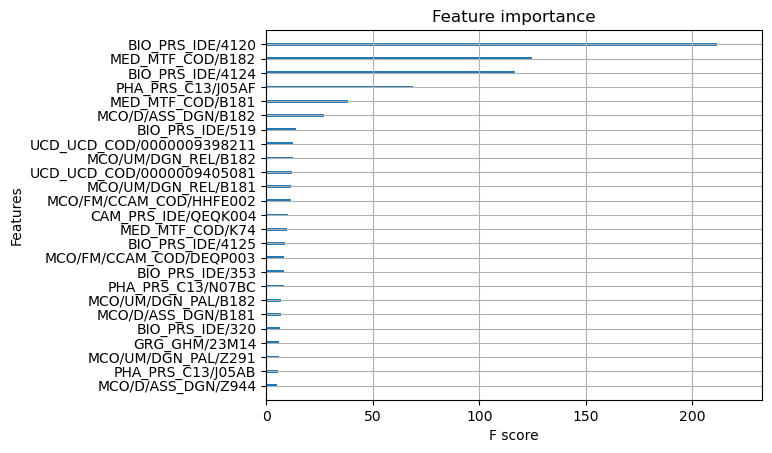

In [26]:
_ = xgb.plot_importance(clf.best_estimator_, 
                        importance_type = "gain",
                        max_num_features = 25,
                        show_values = False)

In [27]:
final = pd.DataFrame(list(zip(y_test, predictions, predictions_score)), columns = ["True", "Pred", "Score"])

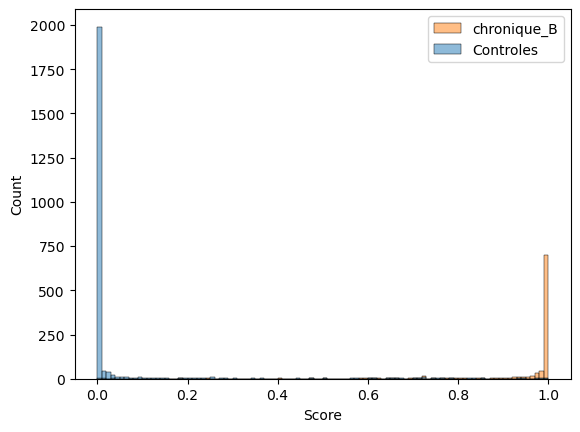

In [28]:
sns.histplot(data = final, x = "Score", hue = "True", bins = 100)
_ = plt.legend(labels = [cat_target, "Controles"])

In [29]:
if curated_vars == None :
    dump(clf, "results/" + cat_target + "/model_cv.joblib")
    clf.best_estimator_.save_model("results/" + cat_target + "/model.json")
    clf.best_estimator_.save_model("results/" + cat_target + "/model.txt")
    clf.best_estimator_.save_model("results/" + cat_target + "/model.ubj")
else:
    dump(clf, "results/" + cat_target + "/model_cv_curated.joblib")
    clf.best_estimator_.save_model("results/" + cat_target + "/model_curated.json")
    clf.best_estimator_.save_model("results/" + cat_target + "/model_curated.txt")
    clf.best_estimator_.save_model("results/" + cat_target + "/model_curated.ubj")

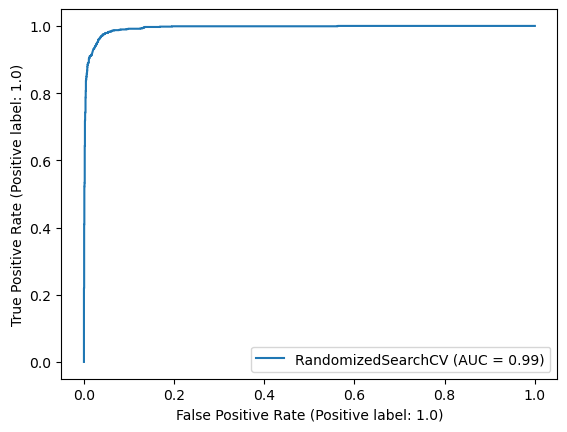

In [41]:
_ = RocCurveDisplay.from_estimator(clf, X_test, y_test)

# Si on faisait tourner l'algorithme sur plusieurs années

In [30]:
# Si au lieu de faire la moyenne sur 3 années on se limitait à une seule

# %%time
# save_score = []

# for myyear in range(12, 22):
#     print(myyear)
    
#     df_temp      = pd.read_csv("results/" + cat_target + "/data/all_numenq_" + str(myyear) + ".csv", sep = ";")
#     data_noleakage = df_temp[~df_temp["NUM_ENQ"].isin(num_enq_train)].copy()

#     X_pred, y_pred = data_noleakage[var_predict], data_noleakage[cat_target]
        
#     predictions_score = clf.predict_proba(X_pred)[:,1]
#     data_noleakage["results" + str(myyear)] = np.round(predictions_score, 2)
    
#     df_temp = data_noleakage[["NUM_ENQ", cat_target, "results" + str(myyear)]]
#     save_score.append(df_temp)
    
# df_total_score = ps.merge_years(save_score, cat_target)

In [31]:
%%time
save_score = []

for myyear in range(13, 21):
    print(myyear)
    
    df_temp_back = pd.read_csv("results/" + cat_target + "/data/all_numenq_" + str(myyear - 1) + ".csv", sep = ";")
    df_temp      = pd.read_csv("results/" + cat_target + "/data/all_numenq_" + str(myyear) + ".csv", sep = ";")
    df_temp_forw = pd.read_csv("results/" + cat_target + "/data/all_numenq_" + str(myyear + 1) + ".csv", sep = ";")
    
    df_temp = pd.concat([df_temp_back, df_temp, df_temp_forw])
    df_temp = df_temp[df_temp["NUM_ENQ"].isin(num_enq_test)]
    df_temp = df_temp.groupby("NUM_ENQ", as_index = False).mean()
    
    data_noleakage = df_temp
    
    X_pred, y_pred = data_noleakage[var_predict], data_noleakage[cat_target]
        
    predictions_score = clf.predict_proba(X_pred)[:,1]
    data_noleakage["results" + str(myyear)] = np.round(predictions_score, 2)
    
    df_temp = data_noleakage[["NUM_ENQ", cat_target, "results" + str(myyear)]]
    save_score.append(df_temp)
    
df_total_score = ps.merge_years(save_score, cat_target)

13
14
15
16
17
18
19
20
Wall time: 7.52 s


In [33]:
df_total_score = pd.merge(left = df_total_score, right = snds_hepather[["NUM_ENQ", "year_incl"]], on = "NUM_ENQ")

In [35]:
if curated_vars == None :
    df_total_score.to_csv("results/" + cat_target + "/df_score_year.csv", sep = ";", index = False)
else:
    df_total_score.to_csv("results/" + cat_target + "/df_score_year_curated.csv", sep = ";", index = False)